# Predicting Bike Rentals

Many U.S. cities have communal bike sharing stations where you can rent bicycles by the hour or day. Washington, D.C. is one of these cities. The District collects detailed data on the number of bicycles people rent by the hour and day.

In this project, I'll attempt to create a model to predict the number of bike rentals making use of historic data. Different machine learning algorithms will be used, and their outcomes compared:
* linear regression
* decision tree regression
* random forest regression

Practicing my data science skills, e.g. by setting up the code such that I can efficiently compare the performance of the various models, is more a goal than creating the "ultimate" predictive model for the case at hand.

The data that I'll make use of was downloaded from [University of California's Irvine Machine Learning Repository](http://archive.ics.uci.edu/dataset/275/bike+sharing+dataset). The dataset contains the hourly count of rental bikes between years 2011 and 2012 in Capital bikeshare system with the corresponding weather and seasonal information. 

Structure of this notebook:
* 1. Preparations and data exploration
* 2. Prepare data for machine learning
* 3. Linear regression
* 4. Decision tree (regression)
* 5. Random forest (regression)
* 6. Conclusions and next steps

## 1. Preparations and data exploration

In this section we will first do some preparations such as importing all libraries. Then the data will be imported and explored, so we have a good understanding of the data prior to using it for a predictive model.

In [1]:
# Import all libraries, etc.
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error

In [2]:
# Always display all columns in the output
pd.options.display.max_columns = None

In [3]:
# Import the data
rentals = pd.read_csv('hour.csv')

# Show basic info
rentals.info()

# Show a sample
rentals.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
instant       17379 non-null int64
dteday        17379 non-null object
season        17379 non-null int64
yr            17379 non-null int64
mnth          17379 non-null int64
hr            17379 non-null int64
holiday       17379 non-null int64
weekday       17379 non-null int64
workingday    17379 non-null int64
weathersit    17379 non-null int64
temp          17379 non-null float64
atemp         17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


Column "cnt" is the number of bicycles rented, so that is the one that we will be aiming to predict based on other columns.

Most other columns either are related to the moment that the bike was rented, or to the weather situation. More details about the columns will be explained ad-hoc where necessary. For the full overview, refer to the [source of this data](http://archive.ics.uci.edu/dataset/275/bike+sharing+dataset).

It looks like the data is very clean: no columns with gaps in the data, and all data has suitable data types. No apparent need to do any data cleaning.

Let's go explore the data, by taking a look at some statistics and plots.

In [4]:
# Check the date range
print (rentals['dteday'].min())
print (rentals['dteday'].max())

2011-01-01
2012-12-31


In [5]:
# Check number of rows per year
rentals['yr'].value_counts()

1    8734
0    8645
Name: yr, dtype: int64

In [6]:
# Check number of rows per calendar month
rentals['mnth'].value_counts().sort_index()

1     1429
2     1341
3     1473
4     1437
5     1488
6     1440
7     1488
8     1475
9     1437
10    1451
11    1437
12    1483
Name: mnth, dtype: int64

So it looks like we have 2 years of data, and that the combination of month and year is unique.

To get some initial idea of the data, let's create a plot of rentals per month.

In [7]:
# Add a column indicating the month
rentals['year_month'] = rentals['dteday'].str[0:7]

# Create (and show) a dataframe with the number of rentals per month
rentals_per_month = rentals.groupby('year_month').sum().reset_index()

rentals_per_month

,year_month,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01,237016,688,0,688,8168,24,2018,429,1014,135.82,140.1854,394.95,135.8697,3073,35116,38189
1,2011-02,657437,649,0,1298,7649,24,1957,436,944,184.30,185.4385,363.25,148.9139,6242,41973,48215
2,2011-03,1242825,990,0,2190,8506,0,2202,541,1135,241.80,237.1618,416.14,169.5245,12826,51219,64045
3,2011-04,1745013,1438,0,2876,8277,24,2279,479,1120,338.66,328.3127,480.45,175.5113,22346,72524,94870
4,2011-05,2349924,1488,0,3720,8556,24,2088,504,1065,429.46,409.8053,530.74,134.8680,31050,104771,135821
5,2011-06,2801160,1680,0,4320,8280,0,2184,528,942,499.02,465.5228,427.14,128.3007,30612,112900,143512
6,2011-07,3439140,2232,0,5208,8556,24,2280,480,866,564.38,528.7312,438.71,127.7206,36452,104889,141341
7,2011-08,3918160,2193,0,5848,8412,0,2124,552,946,515.76,479.2798,457.33,137.5098,28842,107849,136691
8,2011-09,4362228,2343,0,6453,8274,24,2225,501,1192,439.46,407.6798,562.00,109.5268,26545,100873,127418
9,2011-10,5062802,2972,0,7430,8553,24,2181,479,1114,349.12,340.8156,524.96,130.4667,25222,98289,123511


In [8]:
# To validate: total should still be the same
print(rentals['cnt'].sum())
print(rentals_per_month['cnt'].sum())

3292679
3292679


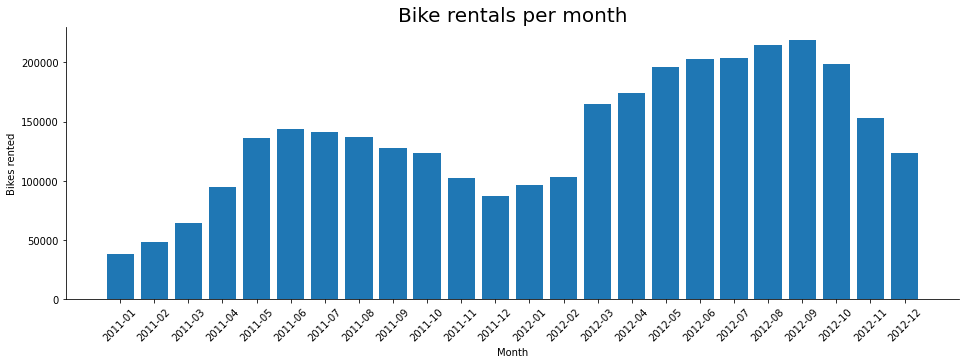

In [9]:
# Create a plot
fig,ax = plt.subplots(figsize=(16, 5))
plt.bar(rentals_per_month['year_month'],rentals_per_month['cnt'])
plt.title('Bike rentals per month', fontsize=20)
ax.set_xlabel("Month")
ax.set_ylabel("Bikes rented")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.show()

What we can observe is:
* there clearly is a seasonal pattern, with higher numbers in summer and lower numbers in winter
* it looks like the 2nd year (2012) consistently has higher numbers than the 1st year (2011)

Let's also get an idea of the distribution of bike rentals over the day.

In [10]:
# Create a dataframe with the number of rentals per month
rentals_per_hourofday = rentals.groupby('hr').sum().reset_index()
rentals_per_hourofday

,hr,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,0,6299998,1815,365,4744,21,2181,496,1015,339.34,327.5020,501.68,117.4366,7375,31755,39130
1,1,6278992,1808,364,4725,21,2178,494,1014,332.58,320.9413,509.85,114.8692,4709,19455,24164
2,2,6253775,1796,363,4696,21,2165,487,1008,325.02,314.0169,512.53,110.4813,3412,12940,16352
3,3,6147304,1770,355,4632,18,2110,470,993,315.82,305.5619,508.66,105.1976,1893,6281,8174
4,4,6198111,1779,360,4645,20,2099,470,994,311.30,301.4870,517.43,108.6015,874,3554,4428
5,5,6279702,1802,364,4719,21,2168,495,1020,312.70,303.3953,532.68,107.7955,1012,13249,14261
6,6,6288923,1811,364,4735,21,2182,496,1052,313.54,304.0473,539.53,114.3484,3017,52115,55132
7,7,6295933,1815,364,4744,21,2182,496,1081,319.22,309.3796,531.37,119.1668,8037,146134,154171
8,8,6296660,1815,364,4744,21,2182,496,1072,330.78,320.0776,510.85,128.3611,15761,245240,261001
9,9,6297387,1815,364,4744,21,2182,496,1079,346.58,333.4857,481.05,139.0477,22458,136980,159438


In [11]:
# To validate: total should still be the same
print(rentals['cnt'].sum())
print(rentals_per_hourofday['cnt'].sum())

3292679
3292679


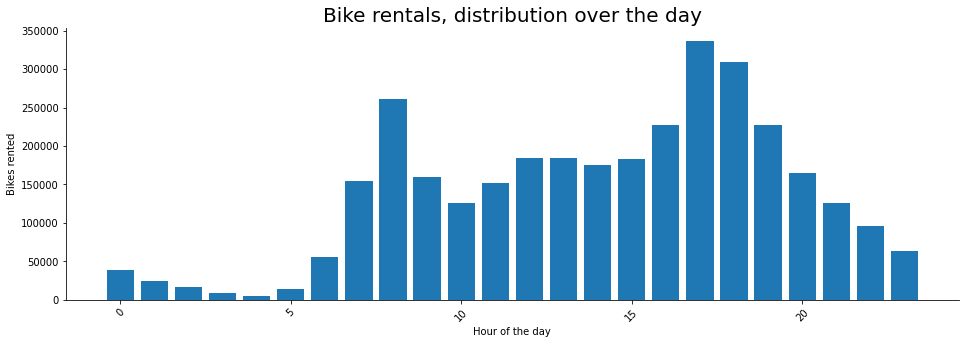

In [12]:
# Create a plot
fig,ax = plt.subplots(figsize=(16, 5))
plt.bar(rentals_per_hourofday['hr'],rentals_per_hourofday['cnt'])
plt.title('Bike rentals, distribution over the day', fontsize=20)
ax.set_xlabel("Hour of the day")
ax.set_ylabel("Bikes rented")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xticks(rotation=45)
plt.show()

We can observe - not unexpectedly of course - many more rentals during day time, and in particular during rush hour, than during the evening and night.

Let's also take a look at a distribution over the days of the week.

In [13]:
# Create a dataframe with the number of rentals per day-of-the-week
rentals_per_dayofweek = rentals.groupby('weekday').mean().reset_index()
rentals_per_dayofweek[['weekday', 'cnt']]

,weekday,cnt
0,0,177.468825
1,1,183.744655
2,2,191.238891
3,3,191.130505
4,4,196.436665
5,5,196.135907
6,6,190.209793


Remarkable little spread actually, even between weekend days and non-weekend days.

Let's also get an idea of the typical number of rentals per hour.

In [14]:
# Understand the range of rental counts
rentals['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

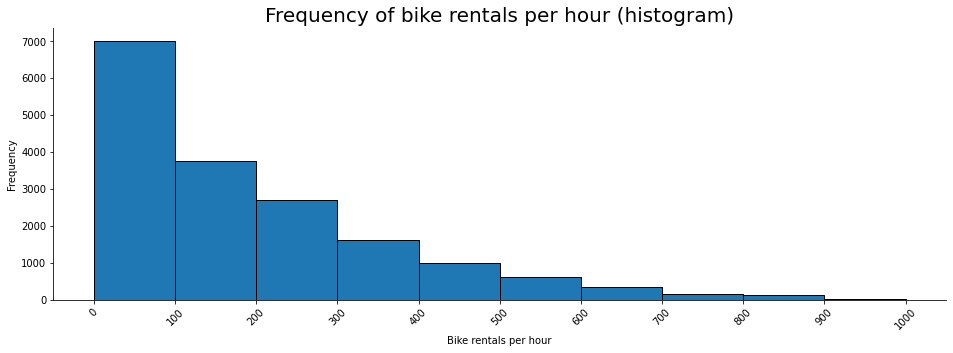

In [15]:
# Create a histogram
fig,ax = plt.subplots(figsize=(16, 5))
plt.hist(rentals['cnt'], bins = range(0,1100,100), ec='black')
plt.title('Frequency of bike rentals per hour (histogram)', fontsize=20)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("Bike rentals per hour")
ax.set_ylabel("Frequency")
plt.xticks(range(0,1100,100))
plt.xticks(rotation=45)
plt.show()

In the busiest hours up to almost 1000 bikes are rented, but rental numbers below 100 per hour are most common. 

Finally let's get an understanding of the correlation between the target column ('cnt') and all other columns.
We'll exclude the columns 'casual' and 'registered', that together just add up to 'cnt'. (As we won't use them we'll just drop them.)

In [16]:
# Drop 2 columns that should not be used
rentals = rentals.drop(['casual', 'registered'], axis = 1)

# Calculate correlation matrix
rentals_correlations = rentals.corr()

# Show the correlation with target column 'cnt'
rentals_correlations['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
cnt           1.000000
Name: cnt, dtype: float64

Most correlation can be seen with 'temp', the (normalized) temperature. (And also with 'atemp', which is also the temparature, but than normalized in a slightly different way). 

Also the correlation with 'hr' (the hour of the day), and 'hum' (the humidity) is high.

Remarkably, also with 'instant', which is just a label of the record, counting 1, 2, 3, .... from the first record onwards. Possibly, this relates to the overall upward trend in bike rentals over time that we also saw in the first graph above? Which also seems to be confirmed by the high correlation with 'yr'.

## 2. Prepare data for machine learning

Having a decent understanding of the data, in this section we'll do several steps to prepare the data for machine learning

### 2.1 Feature engineering

Although we saw some correlations already above, let's add one more feature based on existing columns. We'll add 'time_label', a categorical column that indicates the part of the day, as 'per hour' may be too precise to predict. We'll code it like this:
* 1: morning
* 2: afternoon
* 3: evening
* 4: night

In [17]:
# Create a function that takes in a number representing the hour, and returns a number representing the part of day
# (We already know the inputs range form 0 to 23)
def assign_label(hour_of_day):
    time_label = 4
    if hour_of_day >= 6:
        time_label = 1
    if hour_of_day >= 12:
        time_label = 2
    if hour_of_day >= 18:
        time_label = 3
    return time_label       

In [18]:
# Test function for possible input values:
for an_hour in range(0,24):                  
    print ('Hour', an_hour, 'results in time_label', assign_label(an_hour))

Hour 0 results in time_label 4
Hour 1 results in time_label 4
Hour 2 results in time_label 4
Hour 3 results in time_label 4
Hour 4 results in time_label 4
Hour 5 results in time_label 4
Hour 6 results in time_label 1
Hour 7 results in time_label 1
Hour 8 results in time_label 1
Hour 9 results in time_label 1
Hour 10 results in time_label 1
Hour 11 results in time_label 1
Hour 12 results in time_label 2
Hour 13 results in time_label 2
Hour 14 results in time_label 2
Hour 15 results in time_label 2
Hour 16 results in time_label 2
Hour 17 results in time_label 2
Hour 18 results in time_label 3
Hour 19 results in time_label 3
Hour 20 results in time_label 3
Hour 21 results in time_label 3
Hour 22 results in time_label 3
Hour 23 results in time_label 3


Looks correct. Let's add a column to our dataframe accordingly.

In [19]:
# Apply function to the 'hr' column
rentals['time_label'] = rentals['hr'].apply(assign_label)

# Validate result by showing a random sample
rentals.sample(10)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,year_month,time_label
5362,5363,2011-08-16,3,0,8,8,0,2,1,1,0.70,0.6515,0.58,0.4478,441,2011-08,1
11511,11512,2012-04-29,2,1,4,20,0,0,0,1,0.56,0.5303,0.32,0.0896,243,2012-04,3
8430,8431,2011-12-22,1,0,12,22,0,4,1,3,0.36,0.3636,0.93,0.1045,17,2011-12,3
4088,4089,2011-06-24,3,0,6,6,0,5,1,1,0.66,0.6061,0.83,0.1343,91,2011-06,1
12491,12492,2012-06-09,2,1,6,16,0,6,0,1,0.82,0.6970,0.24,0.1940,534,2012-06,2
10411,10412,2012-03-14,1,1,3,22,0,3,1,1,0.52,0.5000,0.55,0.1343,202,2012-03,3
13589,13590,2012-07-25,3,1,7,10,0,3,1,1,0.74,0.6515,0.37,0.0000,231,2012-07,1
12846,12847,2012-06-24,3,1,6,11,0,0,0,1,0.76,0.6818,0.40,0.1343,506,2012-06,1
15849,15850,2012-10-27,4,1,10,14,0,6,0,1,0.60,0.6212,0.46,0.2537,750,2012-10,2
7488,7489,2011-11-13,4,0,11,15,0,0,0,2,0.50,0.4848,0.42,0.3284,310,2011-11,2


That looks correct.

Let's take another look at the correlation table, now including this feature.

In [20]:
# Calculate correlation matrix
rentals_correlations = rentals.corr()

# Show the correlation with target column 'cnt'
rentals_correlations['cnt']

instant       0.278379
season        0.178056
yr            0.250495
mnth          0.120638
hr            0.394071
holiday      -0.030927
weekday       0.026900
workingday    0.030284
weathersit   -0.142426
temp          0.404772
atemp         0.400929
hum          -0.322911
windspeed     0.093234
cnt           1.000000
time_label   -0.378318
Name: cnt, dtype: float64

The newly added attribute strongly correlates to the number of number of bike rentals, but more or less similarly as the hour of day did. We'll keep it anyway.

### 2.2 Dummy-code categorical features

Quite a few of the columns we have are categorical columns. Since one of the models that we want to use is 'linear regression', we need to dummy code those. They will be added to the data frame.

In [21]:
# Get columns to dummy-code
features_categorical = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'time_label']

# Add dummy coded columns
for feature in features_categorical:
    rentals = pd.concat([rentals, pd.get_dummies(rentals[feature], prefix = 'dummy'+feature, drop_first = False)], axis=1)
    
# To verify completeness of the newly added columns, show column info
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 78 columns):
instant              17379 non-null int64
dteday               17379 non-null object
season               17379 non-null int64
yr                   17379 non-null int64
mnth                 17379 non-null int64
hr                   17379 non-null int64
holiday              17379 non-null int64
weekday              17379 non-null int64
workingday           17379 non-null int64
weathersit           17379 non-null int64
temp                 17379 non-null float64
atemp                17379 non-null float64
hum                  17379 non-null float64
windspeed            17379 non-null float64
cnt                  17379 non-null int64
year_month           17379 non-null object
time_label           17379 non-null int64
dummyseason_1        17379 non-null uint8
dummyseason_2        17379 non-null uint8
dummyseason_3        17379 non-null uint8
dummyseason_4        17379 non-null uint8

In [22]:
# To verify correctness of the newly added columns, show a small sample 
rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,year_month,time_label,dummyseason_1,dummyseason_2,dummyseason_3,dummyseason_4,dummyyr_0,dummyyr_1,dummymnth_1,dummymnth_2,dummymnth_3,dummymnth_4,dummymnth_5,dummymnth_6,dummymnth_7,dummymnth_8,dummymnth_9,dummymnth_10,dummymnth_11,dummymnth_12,dummyhr_0,dummyhr_1,dummyhr_2,dummyhr_3,dummyhr_4,dummyhr_5,dummyhr_6,dummyhr_7,dummyhr_8,dummyhr_9,dummyhr_10,dummyhr_11,dummyhr_12,dummyhr_13,dummyhr_14,dummyhr_15,dummyhr_16,dummyhr_17,dummyhr_18,dummyhr_19,dummyhr_20,dummyhr_21,dummyhr_22,dummyhr_23,dummyholiday_0,dummyholiday_1,dummyweekday_0,dummyweekday_1,dummyweekday_2,dummyweekday_3,dummyweekday_4,dummyweekday_5,dummyweekday_6,dummyworkingday_0,dummyworkingday_1,dummyweathersit_1,dummyweathersit_2,dummyweathersit_3,dummyweathersit_4,dummytime_label_1,dummytime_label_2,dummytime_label_3,dummytime_label_4
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16,2011-01,4,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40,2011-01,4,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32,2011-01,4,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13,2011-01,4,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1,2011-01,4,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1


That looks good good.

### 2.3 Test and train datasets

We'll split the data in training dataset, containing 80% of the data, and a test dataset, containing the remaining 20%.
Rows will be randomly assigned.

In [23]:
# Randomly (but reproducable) select 80% of the rows in the dataframe as training data
train = rentals.sample(frac = 0.8, random_state = 0)

# Everything else: test data
test = rentals.loc[~rentals.index.isin(train.index)]

# To verify the numbers:
print('Rows in training set:', len(train))
print('Rows in test set:', len (test))
print('Total:', len(train)+len(test))
print('Original dataframe total:', len(rentals))

Rows in training set: 13903
Rows in test set: 3476
Total: 17379
Original dataframe total: 17379


In [24]:
# To verify whether train and test are mutually exclusive, show the first couple of rows of 'test'
test.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,year_month,time_label,dummyseason_1,dummyseason_2,dummyseason_3,dummyseason_4,dummyyr_0,dummyyr_1,dummymnth_1,dummymnth_2,dummymnth_3,dummymnth_4,dummymnth_5,dummymnth_6,dummymnth_7,dummymnth_8,dummymnth_9,dummymnth_10,dummymnth_11,dummymnth_12,dummyhr_0,dummyhr_1,dummyhr_2,dummyhr_3,dummyhr_4,dummyhr_5,dummyhr_6,dummyhr_7,dummyhr_8,dummyhr_9,dummyhr_10,dummyhr_11,dummyhr_12,dummyhr_13,dummyhr_14,dummyhr_15,dummyhr_16,dummyhr_17,dummyhr_18,dummyhr_19,dummyhr_20,dummyhr_21,dummyhr_22,dummyhr_23,dummyholiday_0,dummyholiday_1,dummyweekday_0,dummyweekday_1,dummyweekday_2,dummyweekday_3,dummyweekday_4,dummyweekday_5,dummyweekday_6,dummyworkingday_0,dummyworkingday_1,dummyweathersit_1,dummyweathersit_2,dummyweathersit_3,dummyweathersit_4,dummytime_label_1,dummytime_label_2,dummytime_label_3,dummytime_label_4
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32,2011-01,4,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1
13,14,2011-01-01,1,0,1,13,0,6,0,2,0.46,0.4545,0.72,0.2985,94,2011-01,2,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0
26,27,2011-01-02,1,0,1,2,0,0,0,2,0.42,0.4242,1.00,0.2836,9,2011-01,4,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
27,28,2011-01-02,1,0,1,3,0,0,0,2,0.46,0.4545,0.94,0.1940,6,2011-01,4,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1
40,41,2011-01-02,1,0,1,17,0,0,0,1,0.34,0.3333,0.57,0.1940,65,2011-01,2,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0


In [25]:
# And also the first couple of rows of 'train'
train.sort_values('instant').head(15)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,year_month,time_label,dummyseason_1,dummyseason_2,dummyseason_3,dummyseason_4,dummyyr_0,dummyyr_1,dummymnth_1,dummymnth_2,dummymnth_3,dummymnth_4,dummymnth_5,dummymnth_6,dummymnth_7,dummymnth_8,dummymnth_9,dummymnth_10,dummymnth_11,dummymnth_12,dummyhr_0,dummyhr_1,dummyhr_2,dummyhr_3,dummyhr_4,dummyhr_5,dummyhr_6,dummyhr_7,dummyhr_8,dummyhr_9,dummyhr_10,dummyhr_11,dummyhr_12,dummyhr_13,dummyhr_14,dummyhr_15,dummyhr_16,dummyhr_17,dummyhr_18,dummyhr_19,dummyhr_20,dummyhr_21,dummyhr_22,dummyhr_23,dummyholiday_0,dummyholiday_1,dummyweekday_0,dummyweekday_1,dummyweekday_2,dummyweekday_3,dummyweekday_4,dummyweekday_5,dummyweekday_6,dummyworkingday_0,dummyworkingday_1,dummyweathersit_1,dummyweathersit_2,dummyweathersit_3,dummyweathersit_4,dummytime_label_1,dummytime_label_2,dummytime_label_3,dummytime_label_4
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16,2011-01,4,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40,2011-01,4,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13,2011-01,4,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1,2011-01,4,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1
5,6,2011-01-01,1,0,1,5,0,6,0,2,0.24,0.2576,0.75,0.0896,1,2011-01,4,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1
6,7,2011-01-01,1,0,1,6,0,6,0,1,0.22,0.2727,0.80,0.0000,2,2011-01,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0
7,8,2011-01-01,1,0,1,7,0,6,0,1,0.20,0.2576,0.86,0.0000,3,2011-01,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0
8,9,2011-01-01,1,0,1,8,0,6,0,1,0.24,0.2879,0.75,0.0000,8,2011-01,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0
9,10,2011-01-01,1,0,1,9,0,6,0,1,0.32,0.3485,0.76,0.0000,14,2011-01,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0
10,11,2011-01-01,1,0,1,10,0,6,0,1,0.38,0.3939,0.76,0.2537,36,2011-01,1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0


Looks good, looking at the index numbers of both samples, test and train are mutually exclusive.

Another small thing to prepare is specifying the target as a global variable, since this will be the same for all different models that will be used.

In [26]:
# Specify 'target', being the amount of bikes being rented per hour
target = 'cnt'

### 2.4 Select error metric

The error metric that we will use for comparing the predicted value with the actual value is MAE: the mean absolute error. 

Reasons to choose MAE as error metric:
* it is easy to interpret: it just indicates how many bicyles the prediction is off, on average
* it does not penalize larger errors heavier than smaller errors (having an error of '1' three times, counts as heavy as '3' just one time); that seems okay if your purpose would be to do a prediction of the total amount of business

## 3. Linear regression

The first predictive model that we'll create will use linear regression.

To be able to experiment efficiently while varying the input, let's first create a function to train and test (predict), and immediately show the results.

Testing will not only be done on the test set, but also on the train set. This will help to identify till what extent the model is overfitting: in case the results (in terms of the error metric) are very different, the model is overfitting.

In [27]:
# Create function to train a linear regression model, predict with it, and show the results

def train_and_test_lr (features, printdetails = False):
    # Instantiate linear regression model
    lr = LinearRegression()
    
    # Train the model on the train dataset
    lr.fit(train[features], train[target])
    
    # Create predictions on the test test
    test_predictions = lr.predict(test[features])

    print('Model used: Linear Regression \n')
    # (Optionally) show a few sample results 
    if printdetails == True:
        print ('Predictions of the first 5 rows of the test set:')
        for i in range(0,5):
            print ('Row',i,' prediction:', test_predictions[i], ', actual value:',test.iloc[i]['cnt'])
                
    # Show MAE for the test set 
    mean_abs_error = mean_absolute_error(test[target], test_predictions)
    print('Mean absolute error of the test set predictions:', mean_abs_error, '\n')    
    
    # Create predictions on the training set itself
    train_predictions = lr.predict(train[features])
    
    # (Optionally) show a few sample results 
    if printdetails == True:
        print ('Predictions of the first 5 rows of the training set:')
        for i in range(0,5):
            print ('Row',i,' prediction:', train_predictions[i], ', actual value:',train.iloc[i]['cnt'])

    # Show MAE for the training set
    mean_abs_error = mean_absolute_error(train[target], train_predictions)
    print('Mean absolute error of the training set predictions:', mean_abs_error)            
            

Now, let's select the features to use.

For linear regression, of all the columns that we have:
* we should exclude the 'original' categorical features, and instead, include the 'dummy-coded' version of those
* exclude 'instant': even though we saw correlation with the target column, it is just a counter without any functional meaning and should not be used
* exclude 'date-day': for the same reason

It is very questionable what to do with 'yr'. At one hand we could already see there is clearly a relationship between the 'yr' and the number of bike rentals, in the form of a positive trend for the two years that we have data of. If this model were to be used to predict the future, it does not really make sense to use it in this way. For now, given its predictive value we will keep it part of the selection though.

Another thing that we also might want to do better if want to improve the model, is exclusion of columns that are highly related to each other. Such a 'temp' and 'atemp', but also some of the columns around days, months and seasons. And then, 'temp' will also relate to hour-of-the-day and season.

Let's start with this maybe overcomplete selection though.

In [28]:
# Collect all column names to use for linear regression

lr_features = ['temp', 'atemp', 'hum', 'windspeed']
lr_features = lr_features + rentals.select_dtypes(include=['uint8']).columns.to_list()

Now let's run train_and_test with this selection of features.

In [29]:
# Run train_and_test
train_and_test_lr(lr_features, printdetails = True)

Model used: Linear Regression 

Predictions of the first 5 rows of the test set:
Row 0  prediction: -102.3125 , actual value: 32
Row 1  prediction: 134.875 , actual value: 94
Row 2  prediction: -108.0625 , actual value: 9
Row 3  prediction: -100.3125 , actual value: 6
Row 4  prediction: 326.75 , actual value: 65
Mean absolute error of the test set predictions: 74.2989247698504 

Predictions of the first 5 rows of the training set:
Row 0  prediction: 19.3125 , actual value: 7
Row 1  prediction: 7.8125 , actual value: 5
Row 2  prediction: 394.1875 , actual value: 743
Row 3  prediction: 127.625 , actual value: 208
Row 4  prediction: 281.4375 , actual value: 333
Mean absolute error of the training set predictions: 75.76936182838236


These results look pretty bad. Some of the sample predictions even below 0, which is physically impossible (and thus outside the range of actual values). On average we're 75 bicyles off.

One positive things is that the model does not seem to be prone to overfitting, as the results on the training and test are very similar (for the error metric).

While could try still with different sets of features. However, let's instead try a different predictive model altogether.

## 4. Decision tree (regression)

In this section, let's try a decision tree instead.

Like in the section above, let's create a function first to be able to experiment efficiently. Several input parameters will be added to be able to tune the decision tree regressor.

In [30]:
# Create function to train a decision tree regression model, predict with it, and show the results

def train_and_test_dtr (features, minsamplesleaf = 1, maxdepth = None, printdetails = False):
    # Instantiate decision tree regression model
    dtr = DecisionTreeRegressor(random_state = 0, min_samples_leaf = minsamplesleaf, max_depth = maxdepth)
        
    # Train the model on the train dataset
    dtr.fit(train[features], train[target])
    
    # Create predictions on the test test
    test_predictions = dtr.predict(test[features])

    print('Model used: Decision Tree Regression')
    print('Value for min_samples_leaf:', minsamplesleaf)
    print('Value for max_depth', maxdepth)
    
    # (Optionally) show a few sample results 
    if printdetails == True:
        print ('\nPredictions of the first 5 rows of the test set:')
        for i in range(0,5):
            print ('Row',i,' prediction:', test_predictions[i], ', actual value:',test.iloc[i]['cnt'])
                
    # Show MAE for the test set 
    mean_abs_error = mean_absolute_error(test[target], test_predictions)
    print('Mean absolute error of the test set predictions:', mean_abs_error)    
    
    # Create predictions on the training set itself
    train_predictions = dtr.predict(train[features])
    
    # (Optionally) show a few sample results 
    if printdetails == True:
        print ('\nPredictions of the first 5 rows of the training set:')
        for i in range(0,5):
            print ('Row',i,' prediction:', train_predictions[i], ', actual value:',train.iloc[i]['cnt'])

    # Show MAE for the training set
    mean_abs_error = mean_absolute_error(train[target], train_predictions)
    print('Mean absolute error of the training set predictions:', mean_abs_error, '\n')            
            

Then, let's select features. For decision tree regression, of all the columns that we have:

* we should include the 'original'categorical features, and exclude the 'dummy-coded' version of those
* exclude 'instant', 'date-day' for the same reasons as above

The same concern applies regarding the inclusion of the 'yr' column. Also this time we will include it nevertheless.

In [31]:
# Collect all column names to use for decision tree regression

dtr_features = ['temp', 'atemp', 'hum', 'windspeed'] + features_categorical

With those features, train and test our decision tree model.

In [32]:
# Run train_and_test
train_and_test_dtr(dtr_features, 10, None, True)

Model used: Decision Tree Regression
Value for min_samples_leaf: 10
Value for max_depth None

Predictions of the first 5 rows of the test set:
Row 0  prediction: 13.4 , actual value: 32
Row 1  prediction: 105.91666666666667 , actual value: 94
Row 2  prediction: 52.8 , actual value: 9
Row 3  prediction: 14.846153846153847 , actual value: 6
Row 4  prediction: 122.92307692307692 , actual value: 65
Mean absolute error of the test set predictions: 31.09978087564375

Predictions of the first 5 rows of the training set:
Row 0  prediction: 6.714285714285714 , actual value: 7
Row 1  prediction: 5.8 , actual value: 5
Row 2  prediction: 427.07142857142856 , actual value: 743
Row 3  prediction: 191.30769230769232 , actual value: 208
Row 4  prediction: 283.0 , actual value: 333
Mean absolute error of the training set predictions: 26.424603888138577 



Much better results! The MAE is now around 30, where we saw around 75 for linear regression. We do seem to see some overfitting though, as the model performs better on the training set than on the test set.

Now let's try to tune the model, first by experimenting with min_samples_leaf. 

In [33]:
# Experiment with different values for min_samples_leaf (keep max_depth at None)
for i in [1, 5, 10, 15, 20, 25, 50, 100]:
    train_and_test_dtr(dtr_features, i, None, False)

Model used: Decision Tree Regression
Value for min_samples_leaf: 1
Value for max_depth None
Mean absolute error of the test set predictions: 33.95138089758343
Mean absolute error of the training set predictions: 0.007264619146946702 

Model used: Decision Tree Regression
Value for min_samples_leaf: 5
Value for max_depth None
Mean absolute error of the test set predictions: 30.854267357115457
Mean absolute error of the training set predictions: 20.37780163924881 

Model used: Decision Tree Regression
Value for min_samples_leaf: 10
Value for max_depth None
Mean absolute error of the test set predictions: 31.09978087564375
Mean absolute error of the training set predictions: 26.424603888138577 

Model used: Decision Tree Regression
Value for min_samples_leaf: 15
Value for max_depth None
Mean absolute error of the test set predictions: 32.185455601708895
Mean absolute error of the training set predictions: 29.315224900171728 

Model used: Decision Tree Regression
Value for min_samples_leaf

A value of 15 for min_samples_leaf seems pretty good. A relative low error (MAE), and a relatively low difference between the results for training and test prediction accuracy.

Let's also experiment with max_depth.

In [34]:
# Experiment with different values for max_depth (keep min_samples_leaf at 15)
for i in [1, 5, 10, 15, 20, 25, 50, 100]:
    train_and_test_dtr(dtr_features, 15, i, False)

Model used: Decision Tree Regression
Value for min_samples_leaf: 15
Value for max_depth 1
Mean absolute error of the test set predictions: 104.6292066719951
Mean absolute error of the training set predictions: 108.12212689249522 

Model used: Decision Tree Regression
Value for min_samples_leaf: 15
Value for max_depth 5
Mean absolute error of the test set predictions: 69.333867650124
Mean absolute error of the training set predictions: 71.63912592544335 

Model used: Decision Tree Regression
Value for min_samples_leaf: 15
Value for max_depth 10
Mean absolute error of the test set predictions: 36.6386036905351
Mean absolute error of the training set predictions: 34.65958788906628 

Model used: Decision Tree Regression
Value for min_samples_leaf: 15
Value for max_depth 15
Mean absolute error of the test set predictions: 32.137826733152664
Mean absolute error of the training set predictions: 29.427362965534076 

Model used: Decision Tree Regression
Value for min_samples_leaf: 15
Value for 

For max_depth 15 seems a good value as well, however just not setting any value for it (and just letting min_samples_leaf implicitly deciding on the maximum tree depth) seems to be just fine as well.

Summarizing, what we see is that with a decision tree we have much better results than with linear regression, and that with the right choice for min_samples_leaf even not that much overfitting.

Let's nevertheless try whether things can still be improved with a random forest. Which according to theory is less prone to overfitting.

## 5. Random forest (regression)

As mentioned, let's now upgrade to a random forest.

Just like in the sections above, we'll create a function first to be able to experiment efficiently. Several input parameters will be added to be able to tune the random forest regressor.

In [35]:
# Create function to train a random forest regression model, predict with it, and show the results

def train_and_test_rfr (features, nestimators = 100, minsamplesleaf = 15, printdetails = False):
    # Instantiate random forest regression model
    rfr = RandomForestRegressor(random_state = 0, n_estimators = nestimators , min_samples_leaf = minsamplesleaf)    
    
    # Train the model on the train dataset
    rfr.fit(train[features], train[target])
    
    # Create predictions on the test test
    test_predictions = rfr.predict(test[features])

    print('Model used: Random Forest Regression')
    print('Value for n_estimators:', nestimators)
    print('Value for min_samples_leaf:', minsamplesleaf)
    
    # (Optionally) show a few sample results 
    if printdetails == True:
        print ('\nPredictions of the first 5 rows of the test set:')
        for i in range(0,5):
            print ('Row',i,' prediction:', test_predictions[i], ', actual value:',test.iloc[i]['cnt'])
                
    # Show MAE for the test set 
    mean_abs_error = mean_absolute_error(test[target], test_predictions)
    print('Mean absolute error of the test set predictions:', mean_abs_error)    
    
    # Create predictions on the training set itself
    train_predictions = rfr.predict(train[features])
    
    # (Optionally) show a few sample results 
    if printdetails == True:
        print ('\nPredictions of the first 5 rows of the test set:')
        for i in range(0,5):
            print ('Row',i,' prediction:', train_predictions[i], ', actual value:',train.iloc[i]['cnt'])

    # Show MAE for the training set
    mean_abs_error = mean_absolute_error(train[target], train_predictions)
    print('Mean absolute error of the training set predictions:', mean_abs_error, '\n')            
            

We can use the same features as were used for the decision tree.

Let's run train-and-test.

In [36]:
# Run train_and_test
train_and_test_rfr(dtr_features, nestimators = 100, minsamplesleaf = 15, printdetails = True)

Model used: Random Forest Regression
Value for n_estimators: 100
Value for min_samples_leaf: 15

Predictions of the first 5 rows of the test set:
Row 0  prediction: 24.26833627819123 , actual value: 32
Row 1  prediction: 137.0173181683812 , actual value: 94
Row 2  prediction: 47.33960333715492 , actual value: 9
Row 3  prediction: 27.45541407575305 , actual value: 6
Row 4  prediction: 113.9774119315375 , actual value: 65
Mean absolute error of the test set predictions: 30.637269399664977

Predictions of the first 5 rows of the test set:
Row 0  prediction: 7.895716282627404 , actual value: 7
Row 1  prediction: 4.892184599249006 , actual value: 5
Row 2  prediction: 396.8401136428818 , actual value: 743
Row 3  prediction: 174.9389210334335 , actual value: 208
Row 4  prediction: 304.55032210025115 , actual value: 333
Mean absolute error of the training set predictions: 28.770178382697665 



The results (in terms of error metric) are slightly better than with the decision tree, but not much actually.

Let's experiment with some parameters. To start with, with min_samples_leaf.

In [37]:
# Experiment with different values for min_samples_leaf (keep n_estimators at 10)
train_and_test_rfr(dtr_features, 10, 5, False)
train_and_test_rfr(dtr_features, 10, 15, False)
train_and_test_rfr(dtr_features, 10, 25, False)

Model used: Random Forest Regression
Value for n_estimators: 10
Value for min_samples_leaf: 5
Mean absolute error of the test set predictions: 26.796183722894988
Mean absolute error of the training set predictions: 20.89295669809076 

Model used: Random Forest Regression
Value for n_estimators: 10
Value for min_samples_leaf: 15
Mean absolute error of the test set predictions: 31.277379274294635
Mean absolute error of the training set predictions: 29.33805277271013 

Model used: Random Forest Regression
Value for n_estimators: 10
Value for min_samples_leaf: 25
Mean absolute error of the test set predictions: 34.522771068604904
Mean absolute error of the training set predictions: 33.91743518483657 



Just as we saw for the decision tree (and therefore not really surprising), with a value of 15 seems for min_samples_leaf with a we see a relatively small difference between test and training set in terms of accuracy (so not so much overfitting).

However, another interesting observation is that when setting min_samples_leaf to only 5, the overall accuracy seems to improve. But there is overfitting there.

Two things that we can do:
* let's first figure out whether increasing n_estimator (the amount of "trees in the forest") can do something about the overfitting
* then, experiment further with low values for min_sample leaves

In [38]:
# Experiment with different values for n_estimators (keep min_samples_leaf at 5)
train_and_test_rfr(dtr_features, 10, 5, False)
train_and_test_rfr(dtr_features, 20, 5, False)
train_and_test_rfr(dtr_features, 50, 5, False)
train_and_test_rfr(dtr_features, 100, 5, False)
train_and_test_rfr(dtr_features, 200, 5, False)

Model used: Random Forest Regression
Value for n_estimators: 10
Value for min_samples_leaf: 5
Mean absolute error of the test set predictions: 26.796183722894988
Mean absolute error of the training set predictions: 20.89295669809076 

Model used: Random Forest Regression
Value for n_estimators: 20
Value for min_samples_leaf: 5
Mean absolute error of the test set predictions: 26.376848756373303
Mean absolute error of the training set predictions: 20.475571858625827 

Model used: Random Forest Regression
Value for n_estimators: 50
Value for min_samples_leaf: 5
Mean absolute error of the test set predictions: 26.03901427239043
Mean absolute error of the training set predictions: 20.25778296163232 

Model used: Random Forest Regression
Value for n_estimators: 100
Value for min_samples_leaf: 5
Mean absolute error of the test set predictions: 26.026566167079725
Mean absolute error of the training set predictions: 20.14539825059413 

Model used: Random Forest Regression
Value for n_estimators

What we see is a slight improvement of accuracy with an increase of n_estimators, but not much. Unfortunately, we don't see much difference regarding the overfitting.

Let's keep it the number of trees at 50, and experiment again with min_samples_leaf.

In [39]:
# Experiment with different values for min_samples_leaf (keep n_estimators at 10)
train_and_test_rfr(dtr_features, 50, 1, False)
train_and_test_rfr(dtr_features, 50, 2, False)
train_and_test_rfr(dtr_features, 50, 5, False)
train_and_test_rfr(dtr_features, 50, 10, False)
train_and_test_rfr(dtr_features, 50, 15, False)

Model used: Random Forest Regression
Value for n_estimators: 50
Value for min_samples_leaf: 1
Mean absolute error of the test set predictions: 24.79006904487917
Mean absolute error of the training set predictions: 9.707736076146634 

Model used: Random Forest Regression
Value for n_estimators: 50
Value for min_samples_leaf: 2
Mean absolute error of the test set predictions: 24.86461084761358
Mean absolute error of the training set predictions: 13.195089971613813 

Model used: Random Forest Regression
Value for n_estimators: 50
Value for min_samples_leaf: 5
Mean absolute error of the test set predictions: 26.03901427239043
Mean absolute error of the training set predictions: 20.25778296163232 

Model used: Random Forest Regression
Value for n_estimators: 50
Value for min_samples_leaf: 10
Mean absolute error of the test set predictions: 28.299099584601894
Mean absolute error of the training set predictions: 25.575014020722254 

Model used: Random Forest Regression
Value for n_estimators:

What we observe is that, the lower the value of min_samples_leaf:
* the lower the MAE value, not only on the training set itself but also on the test set, indicating better accuracy
* the bigger the gap between MAE for test and training set predictions, indicating more overfitting

It's a bit hard to say what is "best". I am inclined to go somewhere in the middle, e.g. min_samples_leaf is 10. Comparing with the decision tree of the previous section, we then see similar overfitting then, but a slightly
improved accuracy.

## 6. Conclusions and next steps

When comparing the results of the tree predictive models that we created, using MAE (mean absolute error) as error metric, we can see that:
* linear regression gives by far the worst results, with an MAE of around 75
* decision tree regression gives a much better result, with (after some tuning) an MAE of around 30; with some overfitting though when comparing the MAEs on the test set and the original training set (32.1 vs 29.4)
* a random forest improves the results slightly more, giving values of MAE (test, train) of 28.3, 25.6
* somewhat surprisingly, a random forest with a low value for min_samples_leaf appears is overfitting more but also appears to give the most accurate results

As for next steps:
1. For the models used, feature selection could be done a bit more carefully still, e.g. by paying more attention to exclude features that are highly correlated to each other.
2. The most important thing to explore though is whether a predictive model can be selected that could deal better deal with the overall trend of year-over-year growth in bike rentals. From a graph, we could clearly see such trend (be it with only 2 years of data). Keeping the 'year' column in as a predictor felt fundamentally wrong. But so does just ignoring this trend. 